In [167]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [168]:

import re

def parse_prediction(predicted_text_list,unit_list):

    pred_list=[]

    for i in range(len(predicted_text_list)):
        text=predicted_text_list[i]
        unit=unit_list[i]


        #正規表現で､「数値」 + unitを抽出｡数値は小数点やマイナスも含む｡unitの前にスペースがある場合もない場合もある
        #unit_pattern = re.escape(unit).replace(r'\[', r'\[?').replace(r'\]', r'\]?')
        #pattern = rf"-?\d+(\.\d+)?\s*{unit_pattern}"
        # 正規表現によるマッチング
        #match = re.search(pattern, text)

        # 正規表現パターンを定義: "is" の後に数値部分 (-?(\d+(\.\d+)?))
        pattern = r"is\s*(-?\d+(\.\d+)?)"

        # 正規表現によるマッチング
        match = re.search(pattern, text)
        if match:
            predict=(match.group())
            #predict=predict.replace(unit,"").strip()
            #predict=predict.replace(unit[1:-1],"").strip()
            predict=predict.replace("is ","").strip()
            try:
                pred_list.append(float(predict))
            except:
                pred_list.append(None)
        else:
            pred_list.append(None)

    return pred_list

/tmp/ipykernel_986394/2222305441.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["predicted_value_float"][i]=predicted_value_list[i]
/tmp/ipykernel_986394/2222305441.py:32: SettingWithCopyWarning: 
A value is trying to be set on a co

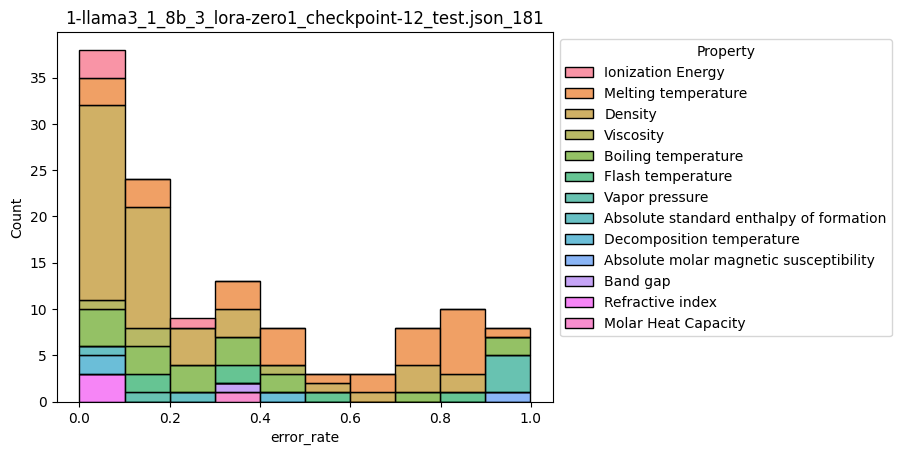

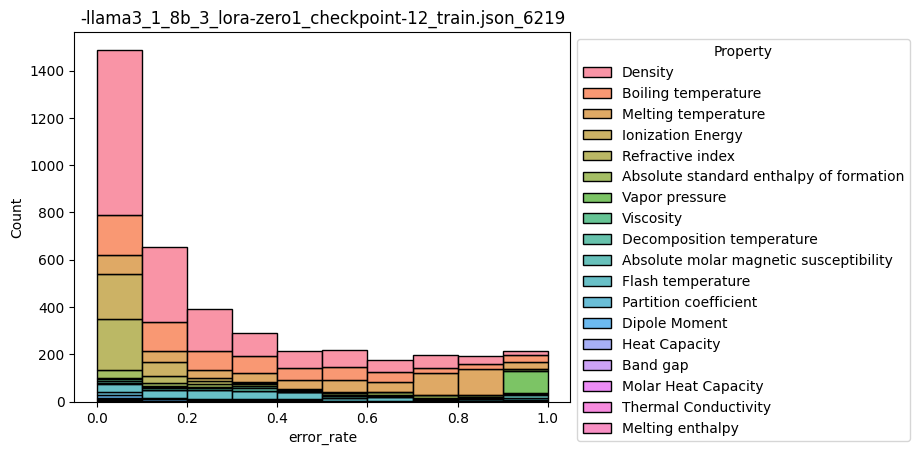

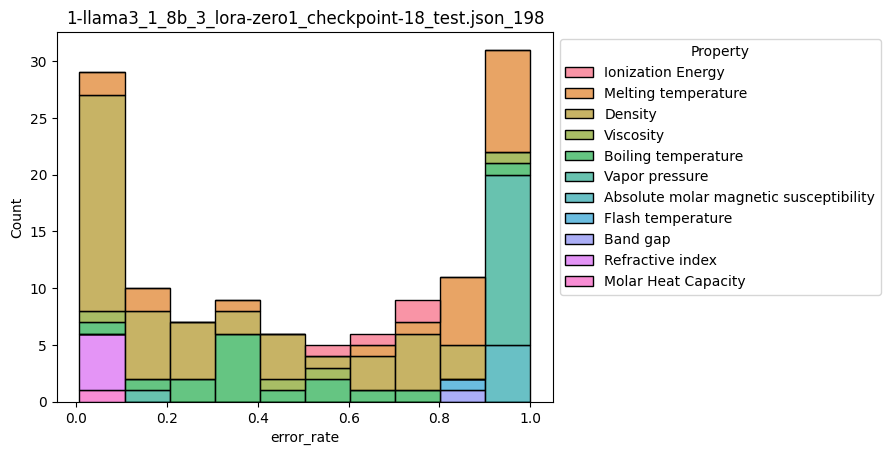

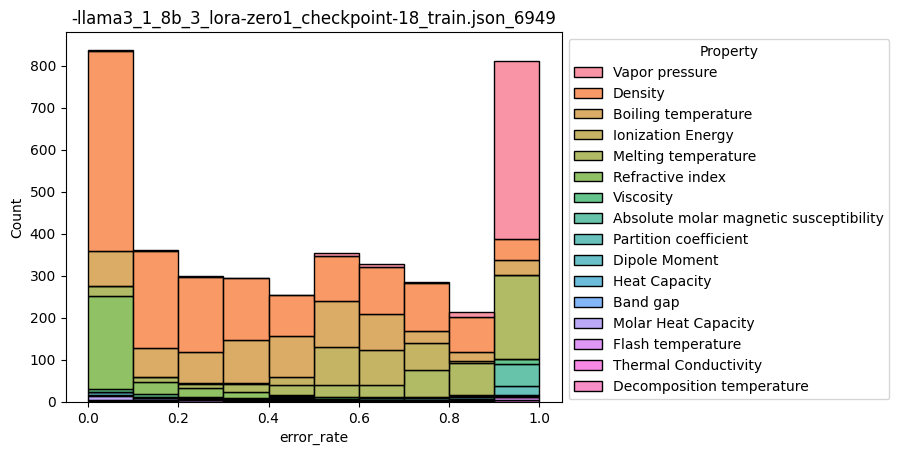

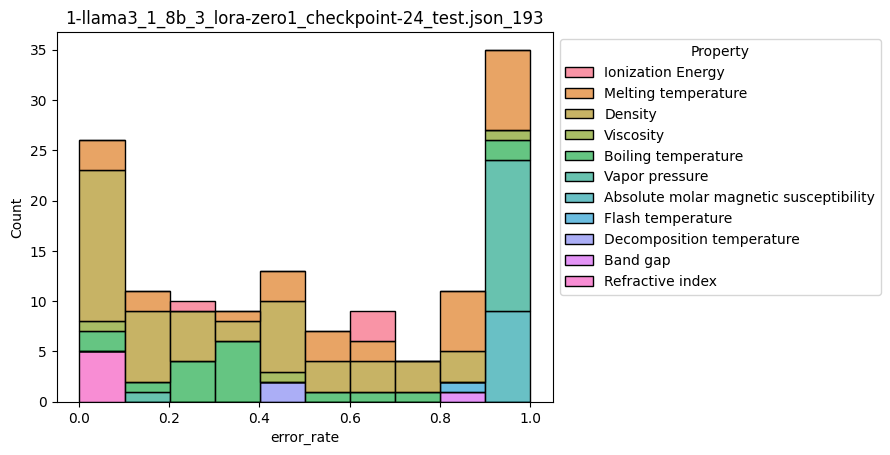

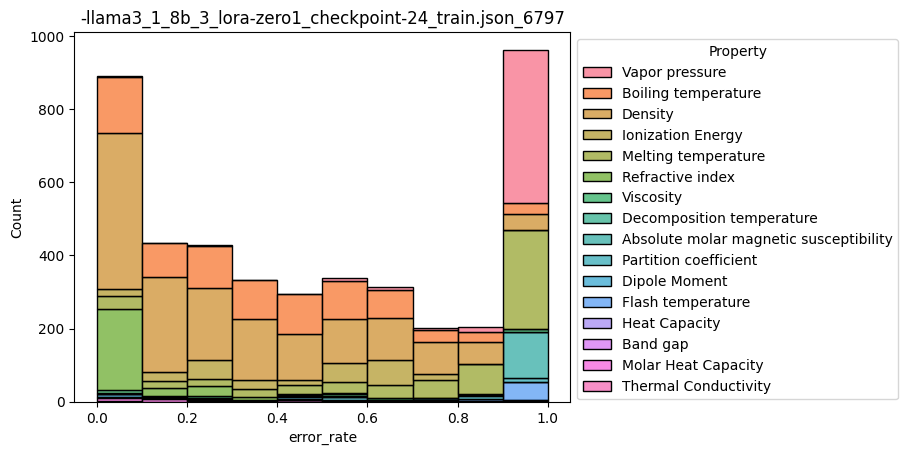

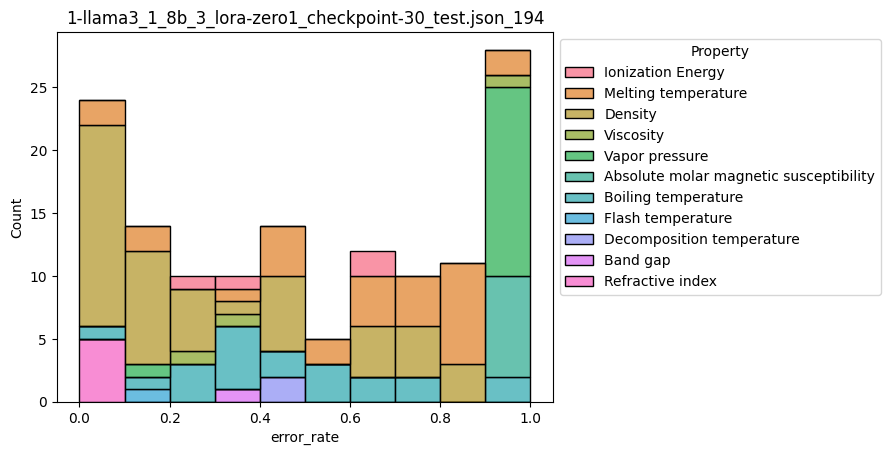

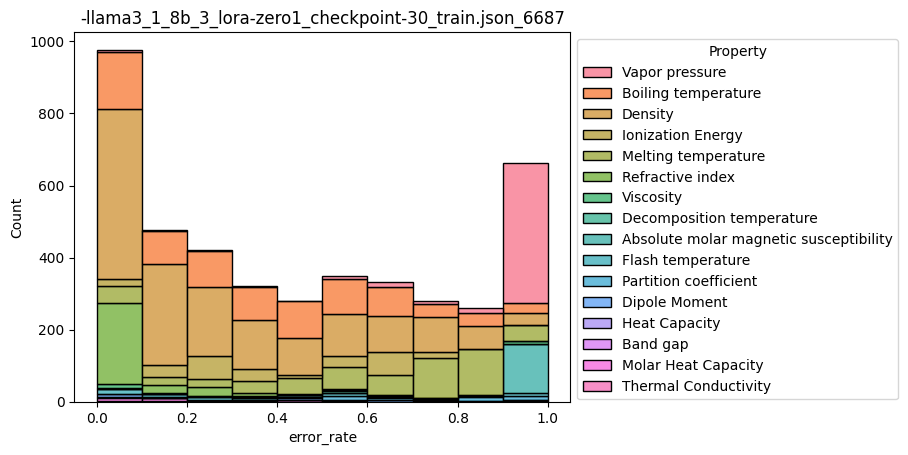

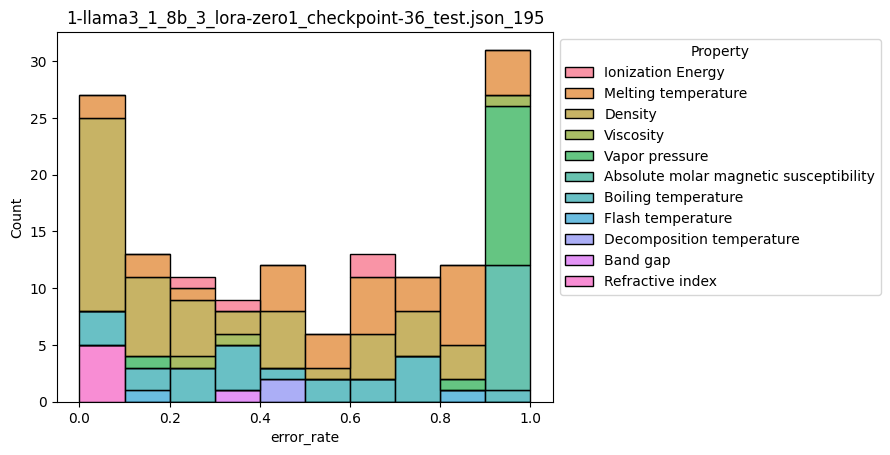

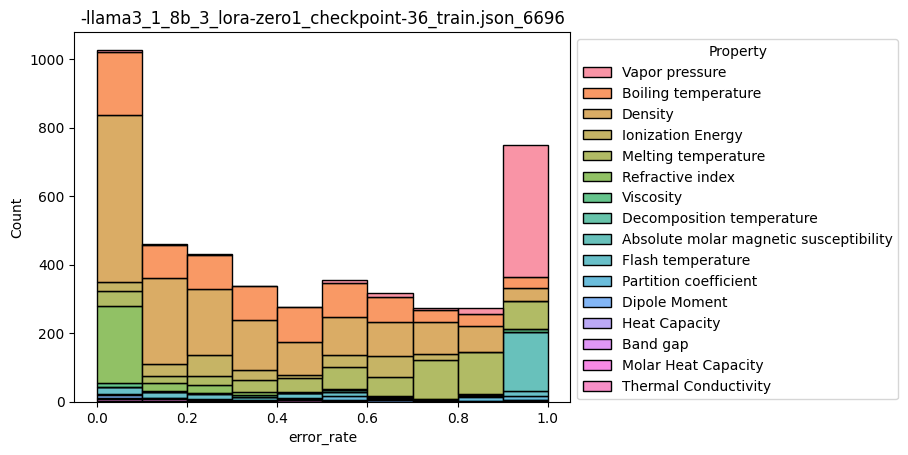

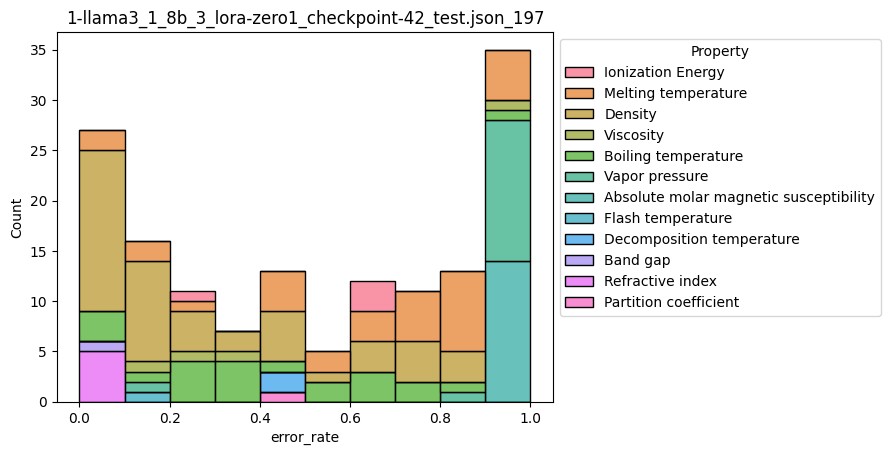

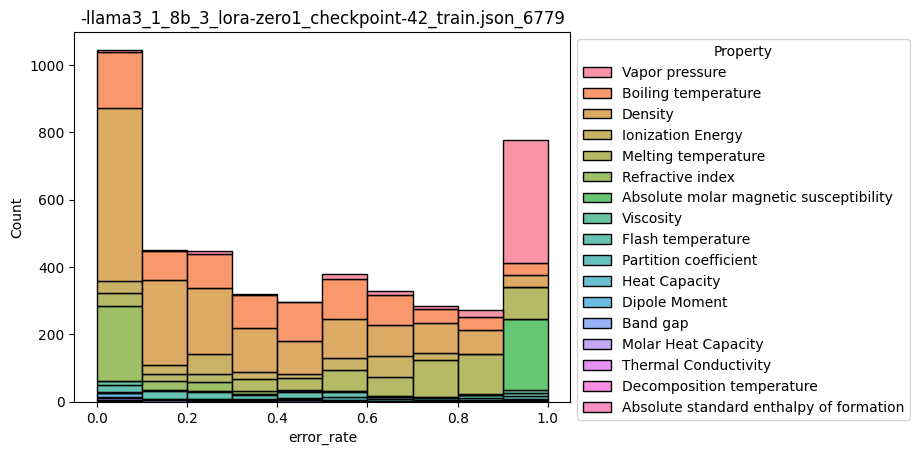

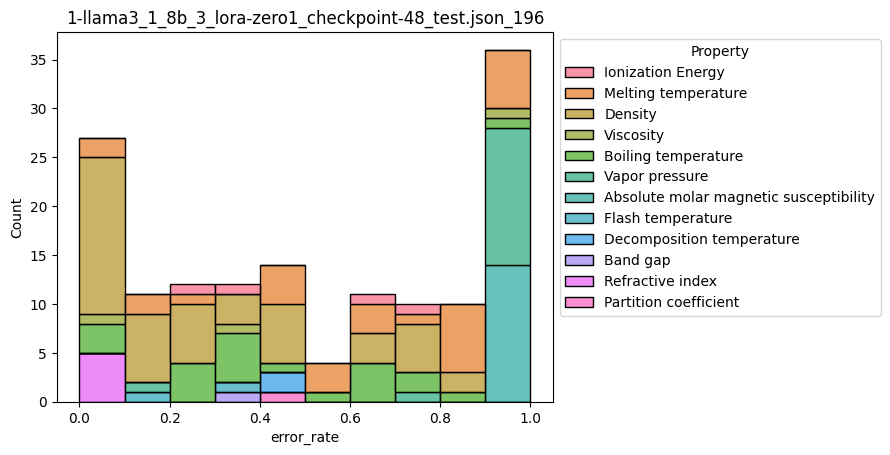

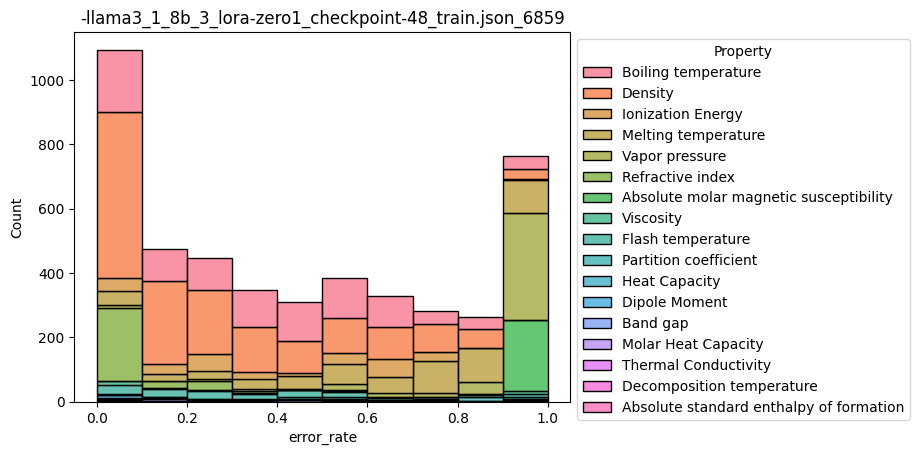

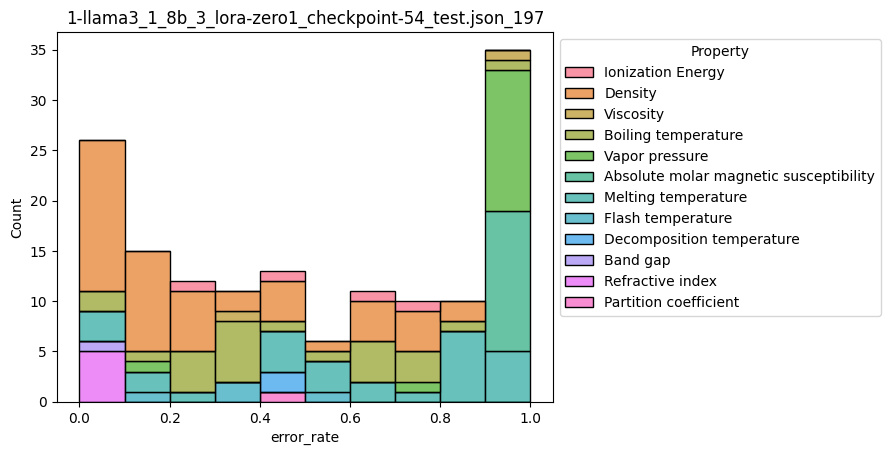

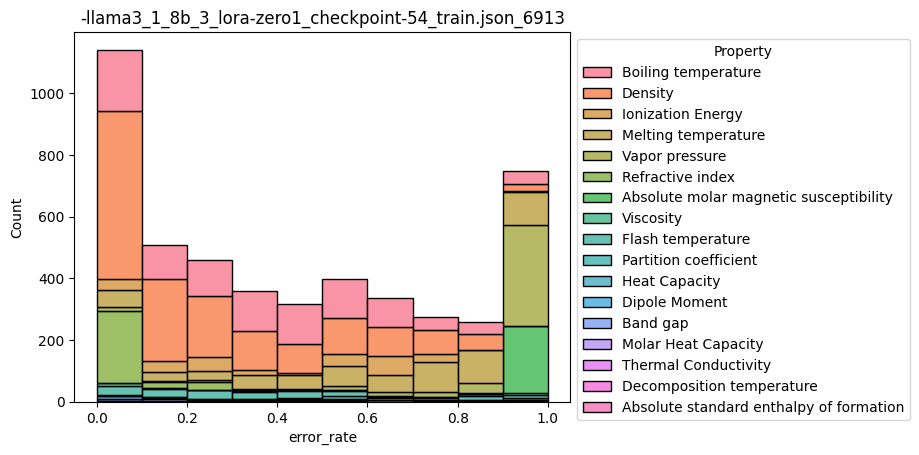

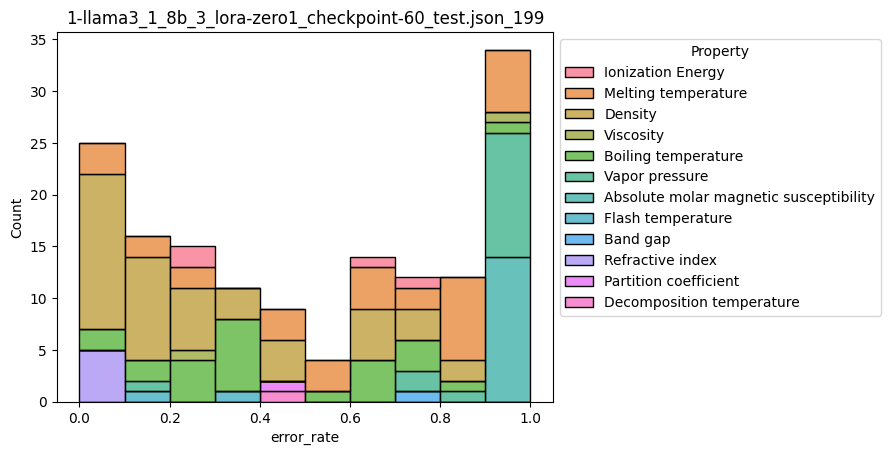

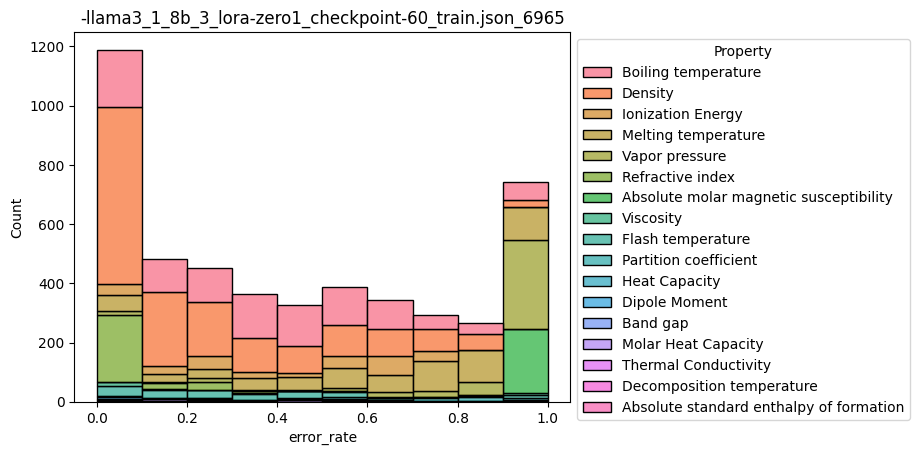

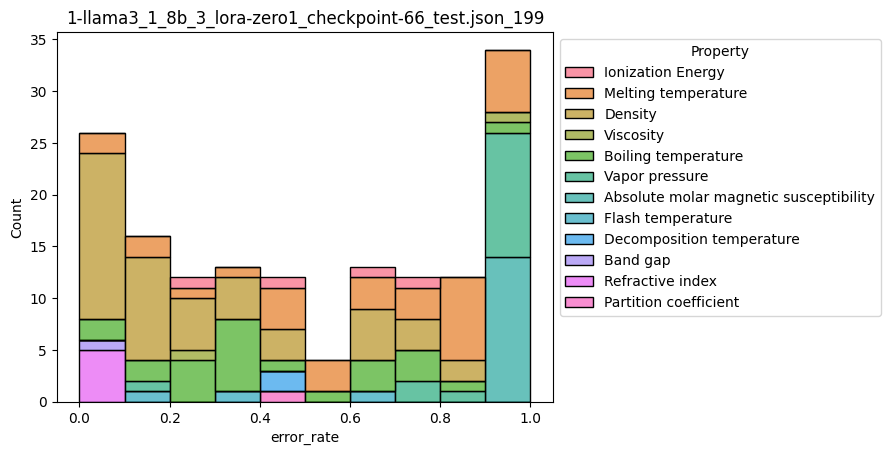

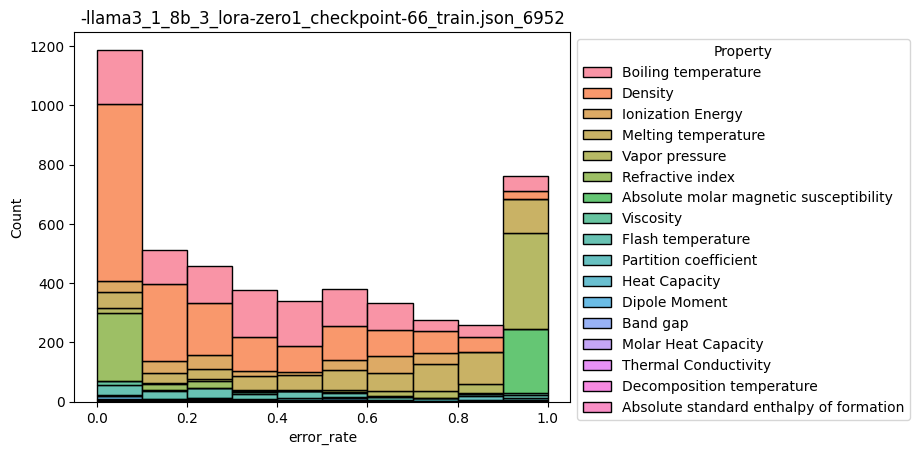

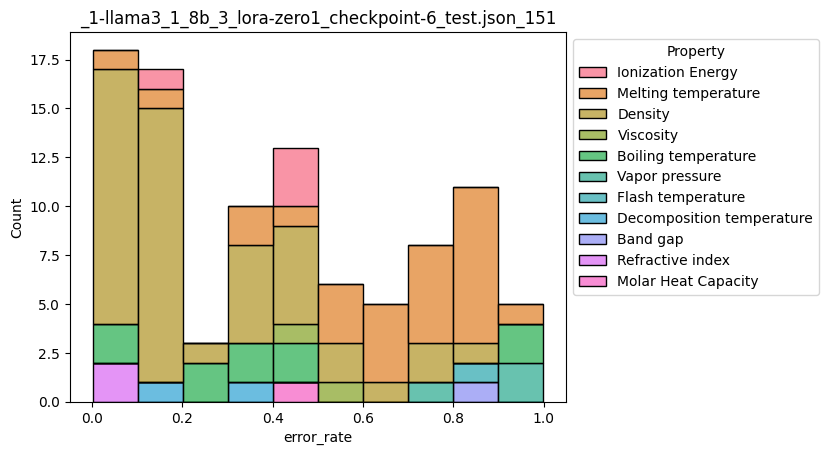

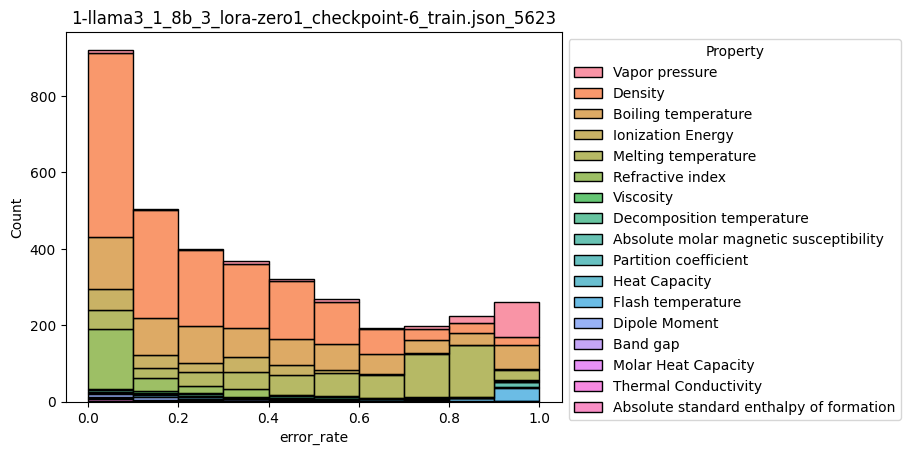

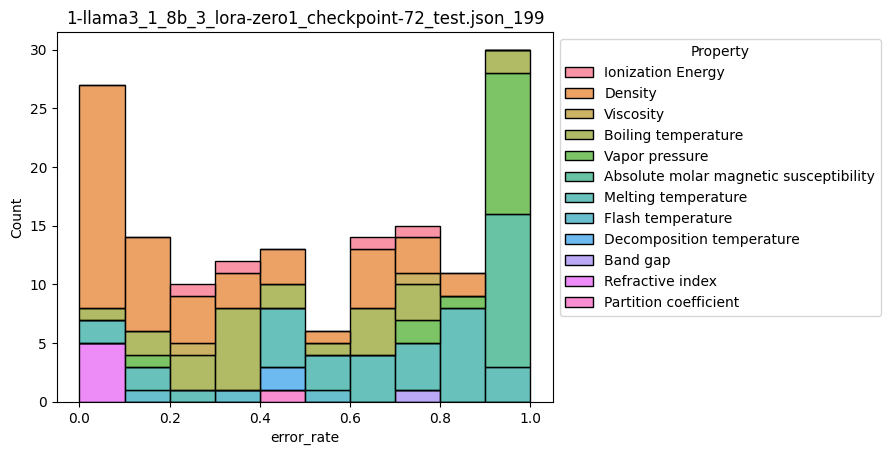

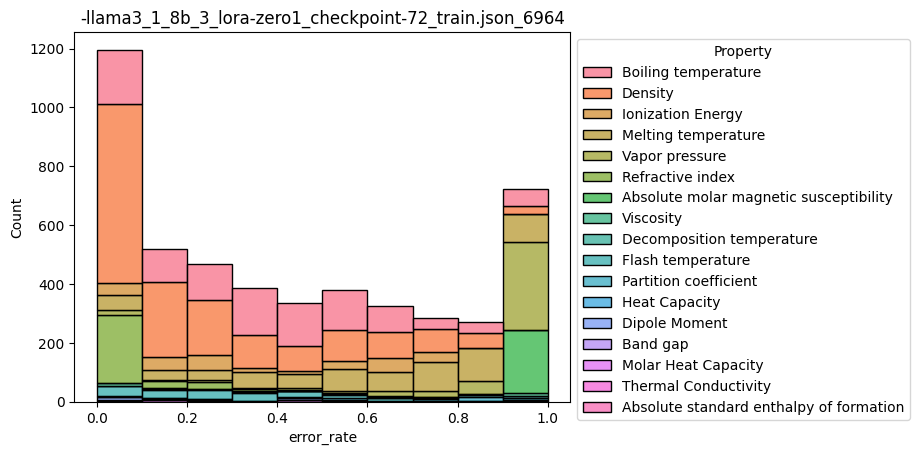

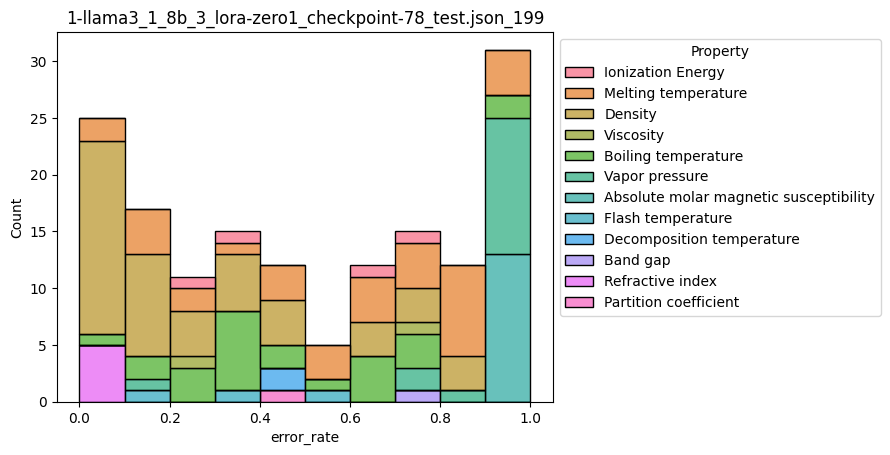

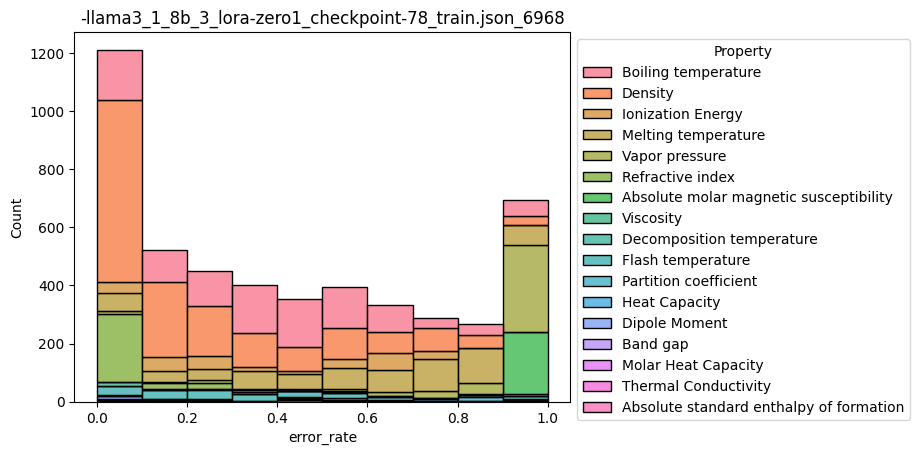

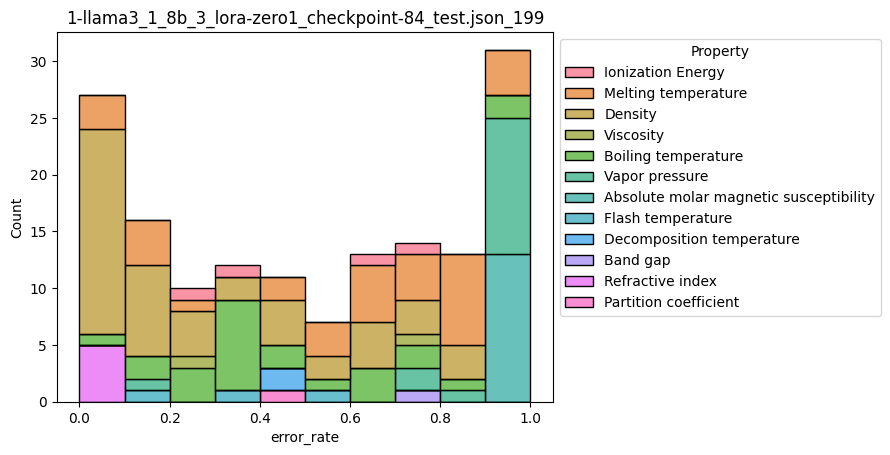

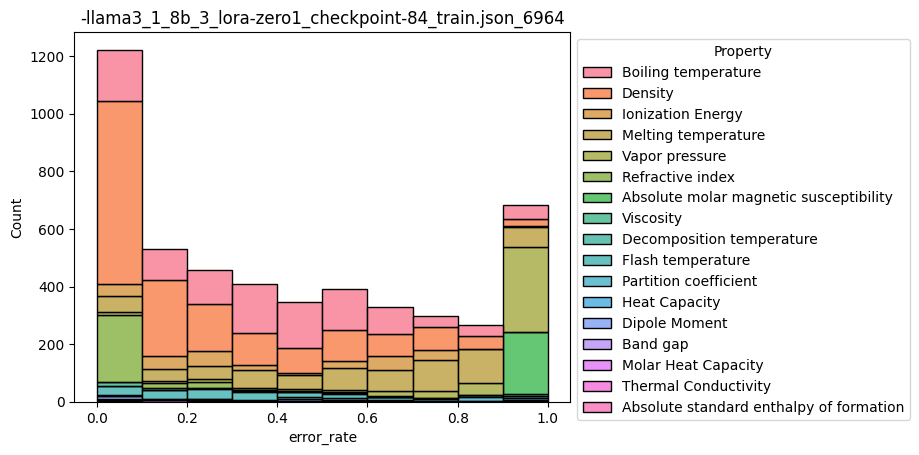

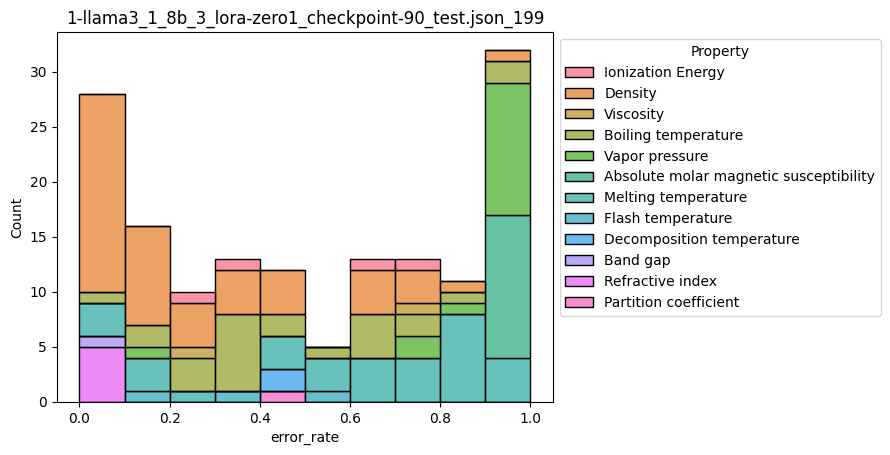

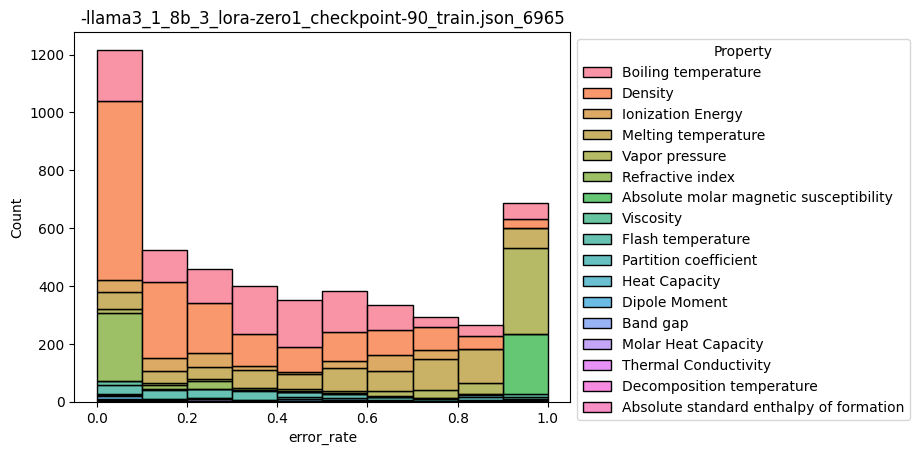

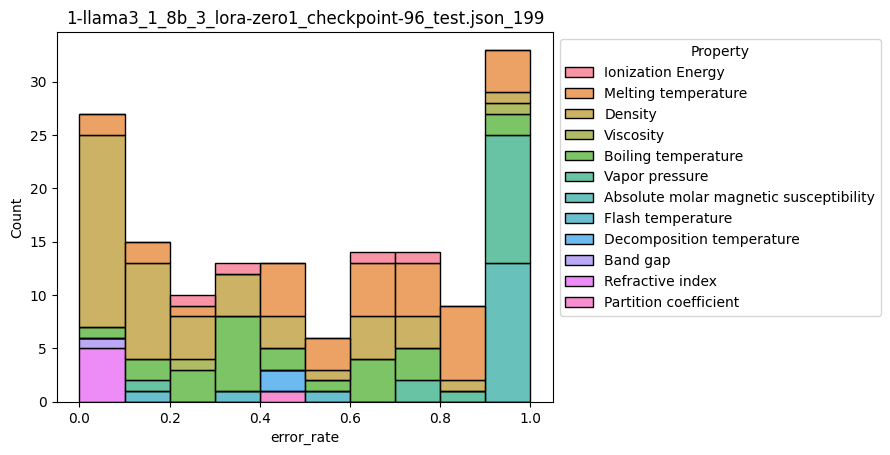

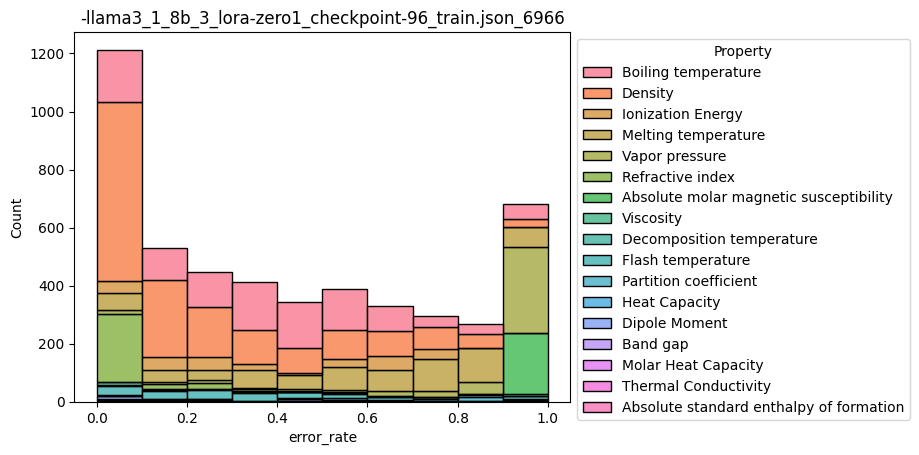

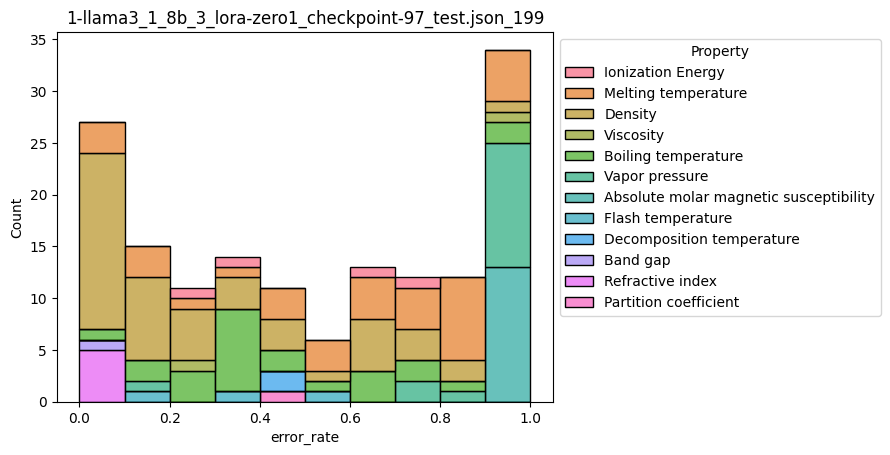

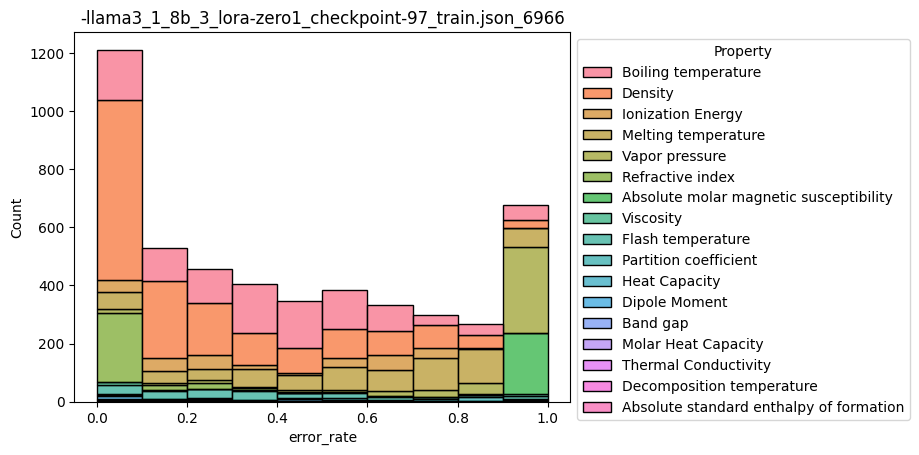

In [169]:
import glob
json_list=[]
#json_list+=glob.glob("eval_results2/*.json")
#json_list+=glob.glob("eval_results_full/*.json")
json_list+=glob.glob("eval_results_lora_llama/*.json")

#json_list+=glob.glob("/data/hatakeyama/self-loop/0920evaluate_prediction_accuracy/eval_results/*.json")

mode="test"

error_rate_dict={}

json_list.sort()

for target_json in json_list:

    #if target_json.find(mode)==-1:
    #    continue

    df=pd.read_json(target_json)
    #predicted_valueをfloatに変更｡変換できないものはNaNにする
    df["predicted_value_float"] = pd.to_numeric(df["predicted_value"], errors='coerce')

    if target_json.find("meta")==-1:
        predicted_text_list=df["predicted_text"].tolist()
        unit_list=df["unit"].tolist()
        predicted_value_list=parse_prediction(predicted_text_list,unit_list)

        #df内がnanの場合は、predicted_value_listを代入
        for i in range(len(predicted_value_list)):
            if pd.isnull(df["predicted_value_float"][i]):
                df["predicted_value_float"][i]=predicted_value_list[i]
        #df["predicted_value_float"]=predicted_value_list


    #actual_value, predicted_valueの誤差率を計算(絶対値を取る
    df["error_rate"]=(df["Value"]-df["predicted_value_float"])/df["Value"]
    df["error_rate"]=df["error_rate"].abs()

    #誤差率が0以上のものを抽出
    sel_df=df[df["error_rate"]>=0]
    sel_df["predicted_text"].tolist()

    #plt.figure()
    #plt.title(target_json)
    #sns.boxplot(x="error_rate",y="Property",data=sel_df)
    #plt.xlim(-1,2)
    #xはlog
    #plt.xscale("log")
    #x=0.1に縦線を引く
    #plt.axvline(x=0.1, color='r', linestyle='--')

    plt.figure()
    plt.title(target_json[-50:]+"_"+str(sel_df.shape[0]))
    #sns.histplot(data=sel_df,x="error_rate",bins=100,hue="Property")
    ax=sns.histplot(data=sel_df[sel_df["error_rate"]<1],x="error_rate",
                 bins=10,hue="Property",
                multiple="stack"
                 )
    #plt.xlim(0,1)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    error_rate_dict[target_json]=sel_df["error_rate"].median()

In [170]:
error_rate_df=pd.DataFrame(error_rate_dict.items(),columns=["json","median_error_rate"])
error_rate_df["json"].to_list()

['eval_results_lora_llama/sftlab_experiments_lora_r_llama_1_output3_1-llama3_1_8b_3_lora-zero1_checkpoint-12_test.json',
 'eval_results_lora_llama/sftlab_experiments_lora_r_llama_1_output3_1-llama3_1_8b_3_lora-zero1_checkpoint-12_train.json',
 'eval_results_lora_llama/sftlab_experiments_lora_r_llama_1_output3_1-llama3_1_8b_3_lora-zero1_checkpoint-18_test.json',
 'eval_results_lora_llama/sftlab_experiments_lora_r_llama_1_output3_1-llama3_1_8b_3_lora-zero1_checkpoint-18_train.json',
 'eval_results_lora_llama/sftlab_experiments_lora_r_llama_1_output3_1-llama3_1_8b_3_lora-zero1_checkpoint-24_test.json',
 'eval_results_lora_llama/sftlab_experiments_lora_r_llama_1_output3_1-llama3_1_8b_3_lora-zero1_checkpoint-24_train.json',
 'eval_results_lora_llama/sftlab_experiments_lora_r_llama_1_output3_1-llama3_1_8b_3_lora-zero1_checkpoint-30_test.json',
 'eval_results_lora_llama/sftlab_experiments_lora_r_llama_1_output3_1-llama3_1_8b_3_lora-zero1_checkpoint-30_train.json',
 'eval_results_lora_llama/sf

<Axes: xlabel='step', ylabel='median_error_rate'>

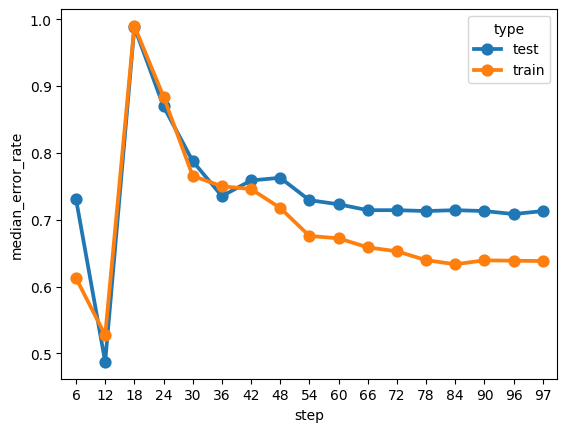

In [171]:
error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["step"] = error_rate_df["step"].fillna(0)
#error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
error_rate_df["type"]=error_rate_df["json"].str.split("_").str[-1].str.split(".").str[0]
sns.pointplot(data=error_rate_df[error_rate_df["json"].str.find("70B")==-1],x="step",y="median_error_rate",hue="type")

In [172]:
#合成された物性データの数
tot_augment_records=1398000*2.5
print("合成された物性データの合計",tot_augment_records)

#元の物性データの数
tot_original_records=7000

#ひとつの物性データがデータベースの中に何回出現するか
total_records_per_property=tot_augment_records/tot_original_records

#今回の学習で使う物性データの数
trained_augment_records=200000
trained_records_per_property=total_records_per_property*trained_augment_records/tot_augment_records
print("今回の学習全体で､特定のpropertyを平均で何回学習するか",trained_records_per_property)

tot_steps=97
seen_times_per_step=trained_records_per_property/tot_steps
print("1stepあたり､特定のpropertyを平均で何回学習するか",seen_times_per_step)

合成された物性データの合計 3495000.0
今回の学習全体で､特定のpropertyを平均で何回学習するか 28.57142857142857
1stepあたり､特定のpropertyを平均で何回学習するか 0.2945508100147275


<Axes: xlabel='Average seen times', ylabel='median_error_rate'>

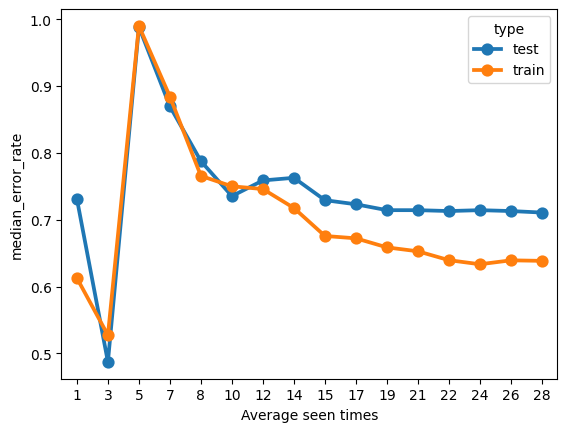

In [173]:

error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["step"] = error_rate_df["step"].fillna(0)
#error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
error_rate_df["type"]=error_rate_df["json"].str.split("_").str[-1].str.split(".").str[0]
error_rate_df["Average seen times"]=(seen_times_per_step*error_rate_df["step"]).astype(int)
sns.pointplot(data=error_rate_df[error_rate_df["json"].str.find("70B")==-1],x="Average seen times",y="median_error_rate",hue="type")

In [174]:
error_rate_df

json  median_error_rate  \
0   eval_results_lora_llama/sftlab_experiments_lor...           0.487179   
1   eval_results_lora_llama/sftlab_experiments_lor...           0.527187   
2   eval_results_lora_llama/sftlab_experiments_lor...           0.988348   
3   eval_results_lora_llama/sftlab_experiments_lor...           0.990000   
4   eval_results_lora_llama/sftlab_experiments_lor...           0.869565   
5   eval_results_lora_llama/sftlab_experiments_lor...           0.884135   
6   eval_results_lora_llama/sftlab_experiments_lor...           0.787619   
7   eval_results_lora_llama/sftlab_experiments_lor...           0.765564   
8   eval_results_lora_llama/sftlab_experiments_lor...           0.735294   
9   eval_results_lora_llama/sftlab_experiments_lor...           0.750000   
10  eval_results_lora_llama/sftlab_experiments_lor...           0.758772   
11  eval_results_lora_llama/sftlab_experiments_lor...           0.745889   
12  eval_results_lora_llama/sftlab_experiments_lor...           0.762719   
13  eval_results_lora_llama/sftlab_experiments_lor...           0.717514   
14  eval_results_lora_llama/sftlab_experiments_lor...           0.729233   
15  eval_results_lora_llama/sftlab_experiments_lor...           0.675676   
16  eval_results_lora_llama/sftlab_experiments_lor...           0.723077   
17  eval_results_lora_llama/sftlab_experiments_lor...           0.672131   
18  eval_results_lora_llama/sftlab_experiments_lor...           0.714286   
19  eval_results_lora_llama/sftlab_experiments_lor...           0.658594   
20  eval_results_lora_llama/sftlab_experiments_lor...           0.730983   
21  eval_results_lora_llama/sftlab_experiments_lor...           0.612648   
22  eval_results_lora_llama/sftlab_experiments_lor...           0.714286   
23  eval_results_lora_llama/sftlab_experiments_lor...           0.652734   
24  eval_results_lora_llama/sftlab_experiments_lor...           0.712963   
25  eval_results_lora_llama/sftlab_experiments_lor...           0.639450   
26  eval_results_lora_llama/sftlab_experiments_lor...           0.714286   
27  eval_results_lora_llama/sftlab_experiments_lor...           0.633333   
28  eval_results_lora_llama/sftlab_experiments_lor...           0.712963   
29  eval_results_lora_llama/sftlab_experiments_lor...           0.639223   
30  eval_results_lora_llama/sftlab_experiments_lor...           0.708455   
31  eval_results_lora_llama/sftlab_experiments_lor...           0.638625   
32  eval_results_lora_llama/sftlab_experiments_lor...           0.712963   
33  eval_results_lora_llama/sftlab_experiments_lor...           0.638215   

        temp  step   type  Average seen times  
0    12_test    12   test                   3  
1   12_train    12  train                   3  
2    18_test    18   test                   5  
3   18_train    18  train                   5  
4    24_test    24   test                   7  
5   24_train    24  train                   7  
6    30_test    30   test                   8  
7   30_train    30  train                   8  
8    36_test    36   test                  10  
9   36_train    36  train                  10  
10   42_test    42   test                  12  
11  42_train    42  train                  12  
12   48_test    48   test                  14  
13  48_train    48  train                  14  
14   54_test    54   test                  15  
15  54_train    54  train                  15  
16   60_test    60   test                  17  
17  60_train    60  train                  17  
18   66_test    66   test                  19  
19  66_train    66  train                  19  
20    6_test     6   test                   1  
21   6_train     6  train                   1  
22   72_test    72   test                  21  
23  72_train    72  train                  21  
24   78_test    78   test                  22  
25  78_train    78  train                  22  
26   84_test    84   test                  24  
27  84_train    84  train                  2

<Axes: xlabel='step', ylabel='median_error_rate'>

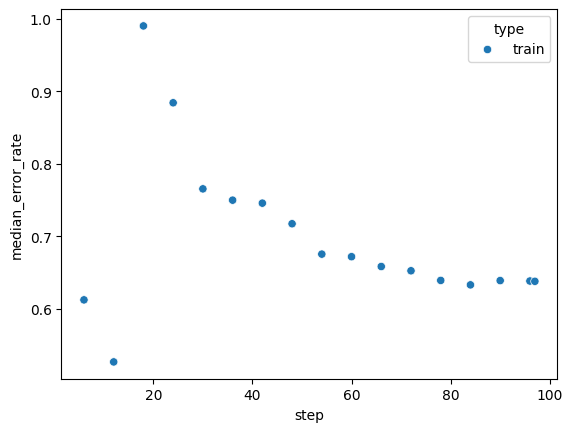

In [175]:

error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
sns.scatterplot(data=error_rate_df[error_rate_df["type"]=="train"],x="step",y="median_error_rate",hue="type")

In [176]:
t="sftlab/experiments/test/1/output3/1-llama3_1_8b_3-zero1/checkpoint-60"
len(t)

69